# Rozpoznawanie mowy - projekt

In [78]:
from scipy.io import wavfile
from matplotlib import pyplot as plt
import numpy as np
import sys
import wave
import scipy.signal
import os
import librosa
import librosa.util
from dtw import dtw
from numpy.linalg import norm
import librosa.display
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

### 1. Funkcja do wczytywania plików z sygnałami (load_voice_signal()). Funkcja normalizuje sygnał poprzez podzielenie sygnału przez moduł sygnału.

In [79]:
def load_voice_signal(filename):
    samplerate, data = wavfile.read('commends/' + filename + '.wav')
    words = data / np.amax(np.absolute(data))
    words = words[::,0]
    timestamps = np.array([i[0] / samplerate for i in np.ndindex(words.shape)])
    return words, timestamps

#### Przykład wizualizacji fali dźwiękowej

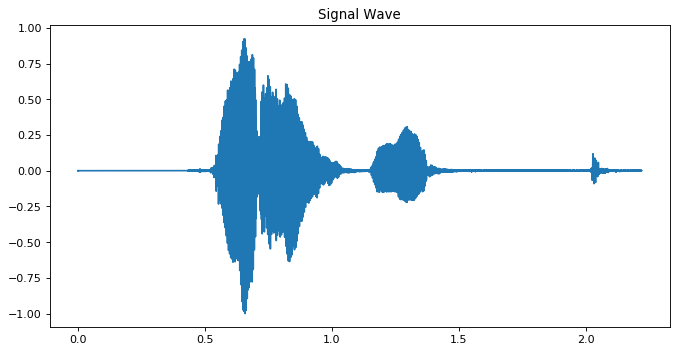

In [80]:
words, timestamps = load_voice_signal('G11')

#y = words[32000:70000]
#x = timestamps[32000:70000]
y = words
x = timestamps
plt.figure(figsize=(10, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.title('Signal Wave')

plt.plot(x,y)

plt.show()

### 2. Funkcja, która wyciąga cechy sygnału (extract_features()).

In [81]:
def extract_features(word):
    my_mfcc = np.mean(librosa.feature.mfcc(y = word, sr = 44100, n_mfcc = 40).T, axis = 0)
    my_mfcc = np.array([my_mfcc])
    return my_mfcc

# Ekstrakcja cech i podział na zbiór uczący i testowy w stosunku 4:1.
### Podział przeprowadzony w sposób losowy

In [82]:
from sklearn.model_selection import train_test_split

commands = ['otwórz', 'zamknij', 'gorąco', 'zimno', 'ciemno', 'jasno', 'stop', 'rozwiń', 'zasłoń']

file_ids, commands = zip(*[(person + str(cmd_idx * 5 + n_record + 1), cmd)
                      for cmd_idx, cmd in enumerate(commands)
                      for person in 'OJG'
                      for n_record in range(5)])

words = [load_voice_signal(file_id)[0] for file_id in file_ids]

features = np.squeeze([extract_features(word) for word in words])

(features_train, features_test,
words_train, words_test,
commands_train, commands_test) = train_test_split(features, words, commands, test_size=0.2)

### Support Vector Classification - Wspierający wektor klasyfikacji:

https://www.icsr.agh.edu.pl/~dzwinel/files/courses/C3-Classifiers.pdf



In [83]:
my_svc = SVC(kernel = "linear", C = 0.025)
my_svc.fit(features_train, commands_train)
predictions = my_svc.predict(features_test)
print('Dokładność klasyfikatora:{}'.format(accuracy_score(commands_test, predictions)))

Dokładność klasyfikatora:0.48148148148148145


#### Trzeba znaleźć jakiś algorytm uczenia, przykładowy algorytm: https://blog.manash.me/building-a-dead-simple-word-recognition-engine-using-convnet-in-keras-25e72c19c12b

Uważam, że różnice pomiędzy tymi samymi słowami sa na tyle duże, że nie bedziemy w stanie nauczyć sieci => można zapisać to we wnioskach

### 5. Porównanie sygnałów używając DWT
http://cs.uccs.edu/~cs525/studentproj/projS2010/plama/doc/cs525-SpeechRecogntion.pdf

http://research.cs.tamu.edu/prism/lectures/sp/l9.pdf

http://web.science.mq.edu.au/~cassidy/comp449/html/ch11s02.html

https://github.com/crawles/dtw/blob/master/Speech_Recognition_DTW.ipynb

http://iosrjournals.org/iosr-jece/papers/NCIEST/Volume%202/3.%2012-16.pdf



Obliczenie znormalizowanej odległości między komendami: zamknij oraz stop korzystając z metody DWT

Różnica odległości między komendą zamknij oraz stop 160.65010653932367


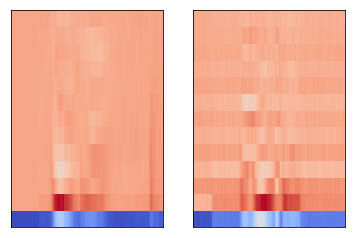

In [85]:
fs = 44100 # częstotliwość próbkowania sygnału
same_words1 = [word for word, cmd in zip(words_test, commands_test) if cmd == 'zamknij']
same_words2 = [word for word, cmd in zip(words_test, commands_test) if cmd == 'stop']
word_1 = librosa.feature.mfcc(same_words1[1], fs, n_mfcc = 13)
plt.subplot(1, 2, 1)
librosa.display.specshow(word_1)
word_2 = librosa.feature.mfcc(same_words1[2], fs, n_mfcc = 13)
plt.subplot(1, 2, 2)

librosa.display.specshow(word_2)

dist, cost, acc_cost, path = dtw(word_2.T, word_1.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
print('Różnica odległości między komendą zamknij oraz stop' , dist)


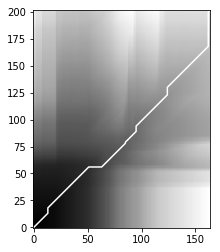

In [86]:
plt.imshow(acc_cost.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.show()

Obliczenie znormalizowanej odległości między komendą otwórz u dwóch różnych osób:

Różnica odległości między otwórz u dwóch różnych osób 4.756999420506903


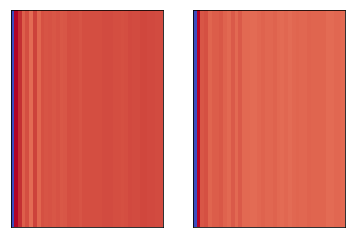

In [87]:
path1 = 'J' + str(1)        
path2 = 'O' + str(1)
word_1 = extract_features(load_voice_signal(path1)[0])
word_2 = extract_features(load_voice_signal(path2)[0])
plt.subplot(1, 2, 1)
librosa.display.specshow(word_1)
plt.subplot(1, 2, 2)
librosa.display.specshow(word_2)

dist, cost, acc_cost, path = dtw(word_2.T, word_1.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
print('Różnica odległości między otwórz u dwóch różnych osób' , dist)

Obliczenie znormalizowanej odległości między komendą zamknij u jednej osoby:

Różnica odległości między otwórz u tej samej osoby: 1.9417552141448073


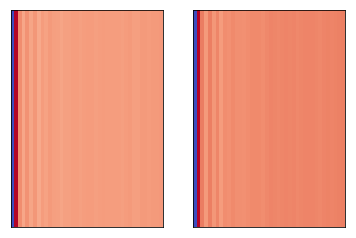

In [88]:
path1 = 'J' + str(6)        
path2 = 'J' + str(10)
word_1 = extract_features(load_voice_signal(path1)[0])
word_2 = extract_features(load_voice_signal(path2)[0])
plt.subplot(1, 2, 1)
librosa.display.specshow(word_1)
plt.subplot(1, 2, 2)
librosa.display.specshow(word_2)

dist, cost, acc_cost, path = dtw(word_2.T, word_1.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
print('Różnica odległości między otwórz u tej samej osoby:' , dist)


# Wnioski

1. Sygnał mowy jest sygnałem ciężkim do analizy. Zależy on od barwy głosu, od stanu emocjonalnego danej osoby (czy wypowiada się będąc spokojnym czy zdenerwowanym) czy też stopnia zmęczenia. Z tego względu zbiór nagrań zawierający te samo sowo może mieć wysokie odchylenie standardowe odległości, co może spowodować błędną klasyfikację. Szczególnie, jeżeli analizowane sygnały pochodzą od wielu osób. 
 
2. Problemem podczas wykonywania projektu, była niewielka próba - posiadano zaledwie 15 nagrań tego samego słowa. Były to słowa nagrywane przez trzy osoby pięciokrotnie w różnych porach dnia i o różnym stopniu zmęczenia i nastroju osoby nagrywającej słowa. W związku z tym należałoby znormalizować sposób akwizycji sygnałów oraz stworzyć większą bazę danych. 


### TODO 
Ta kolorowa macierz ?

proownanie slowa goraco wypowiedziane przez ta sama osobe

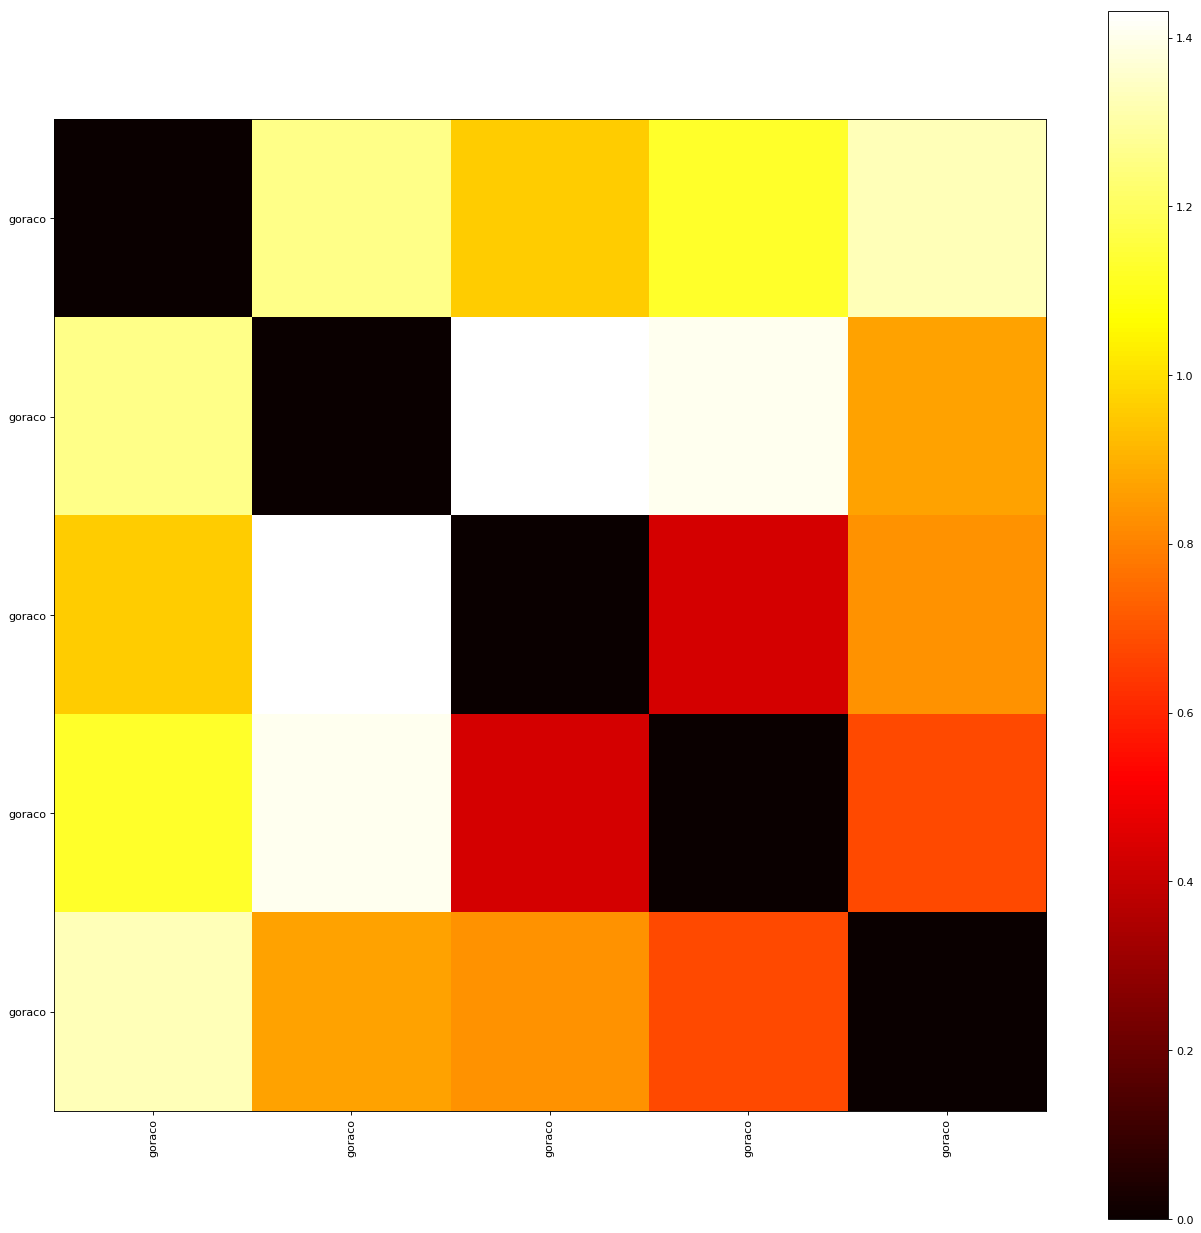

In [95]:
my_dist = np.ndarray(shape = (5, 5))
my_com = ['goraco'] *5 

path = 'G' + str(11)
my_dist1 = extract_features(load_voice_signal(path)[0])

path = 'G' + str(12)
my_dist2 = extract_features(load_voice_signal(path)[0])

path = 'G' + str(13)
my_dist3= extract_features(load_voice_signal(path)[0])

path = 'G' + str(14)
my_dist4 = extract_features(load_voice_signal(path)[0])

path = 'G' + str(15)
my_dist5 = extract_features(load_voice_signal(path)[0])

dist, cost, acc_cost, path = dtw(my_dist1.T, my_dist1.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][0] = dist

dist, cost, acc_cost, path = dtw(my_dist2.T, my_dist2.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][1] = dist

dist, cost, acc_cost, path = dtw(my_dist3.T, my_dist3.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][2] = dist

dist, cost, acc_cost, path = dtw(my_dist4.T, my_dist4.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[3][3] = dist

dist, cost, acc_cost, path = dtw(my_dist5.T, my_dist5.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[4][4] = dist

dist, cost, acc_cost, path = dtw(my_dist1.T, my_dist2.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][1] = dist
my_dist[1][0] = dist

dist, cost, acc_cost, path = dtw(my_dist1.T, my_dist3.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][2] = dist
my_dist[2][0] = dist


dist, cost, acc_cost, path = dtw(my_dist1.T, my_dist4.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][3] = dist
my_dist[3][0] = dist


dist, cost, acc_cost, path = dtw(my_dist1.T, my_dist5.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][4] = dist
my_dist[4][0] = dist


dist, cost, acc_cost, path = dtw(my_dist2.T, my_dist3.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][2] = dist
my_dist[2][1] = dist


dist, cost, acc_cost, path = dtw(my_dist2.T, my_dist4.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][3] = dist
my_dist[3][1] = dist


dist, cost, acc_cost, path = dtw(my_dist2.T, my_dist5.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][4] = dist
my_dist[4][1] = dist

dist, cost, acc_cost, path = dtw(my_dist3.T, my_dist4.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][3] = dist
my_dist[3][2] = dist


dist, cost, acc_cost, path = dtw(my_dist3.T, my_dist5.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][4] = dist
my_dist[4][2] = dist


dist, cost, acc_cost, path = dtw(my_dist4.T, my_dist5.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[3][4] = dist
my_dist[4][3] = dist

        
plt.figure(figsize=(20,20), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(my_dist, cmap='hot')
plt.colorbar()
plt.tick_params(axis = 'on', bottom='off', top='on', labelbottom='off', labeltop='on')
plt.xticks(range(len(my_dist)), my_com, rotation=90)
plt.yticks(range(len(my_dist)), my_com)
plt.show()



### Macierz porównania słowa otworz dla trzech różnych osób

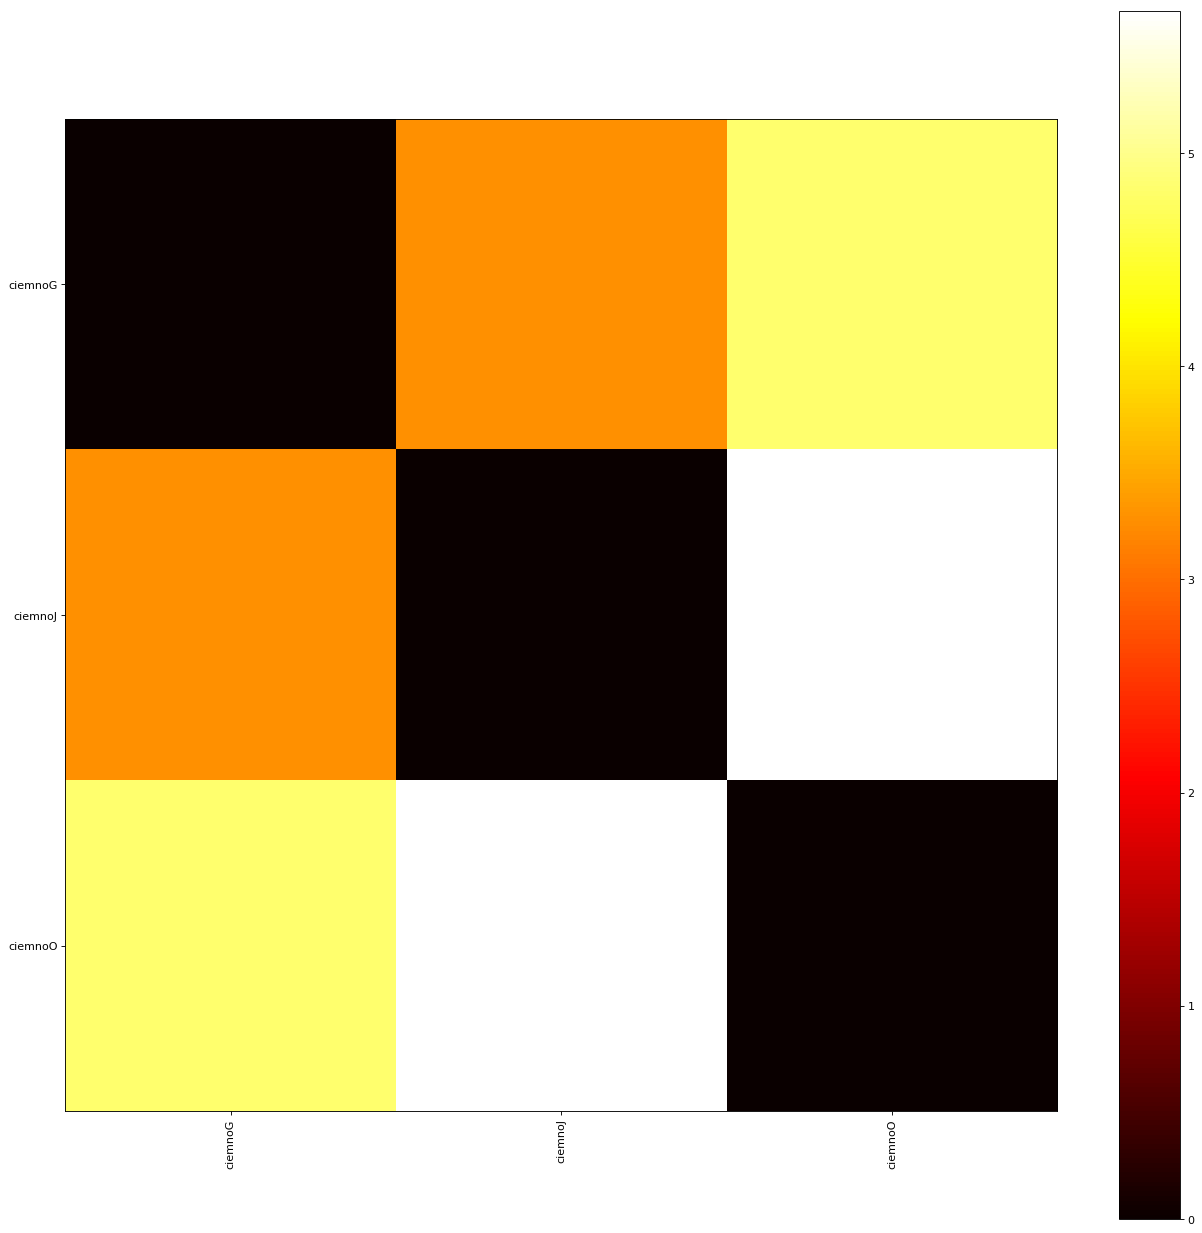

In [100]:
my_dist = np.ndarray(shape = (3, 3))
my_com = ['ciemnoG', 'ciemnoJ', 'ciemnoO']

path = 'G' + str(2)
my_dist1 = extract_features(load_voice_signal(path)[0])

path = 'J' + str(2)
my_dist2 = extract_features(load_voice_signal(path)[0])

path = 'O' + str(2)
my_dist3= extract_features(load_voice_signal(path)[0])


dist, cost, acc_cost, path = dtw(my_dist1.T, my_dist1.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][0] = dist

dist, cost, acc_cost, path = dtw(my_dist2.T, my_dist2.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][1] = dist

dist, cost, acc_cost, path = dtw(my_dist3.T, my_dist3.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][2] = dist


dist, cost, acc_cost, path = dtw(my_dist1.T, my_dist2.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][1] = dist
my_dist[1][0] = dist

dist, cost, acc_cost, path = dtw(my_dist1.T, my_dist3.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][2] = dist
my_dist[2][0] = dist



dist, cost, acc_cost, path = dtw(my_dist2.T, my_dist3.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][2] = dist
my_dist[2][1] = dist


        
plt.figure(figsize=(20,20), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(my_dist, cmap='hot')
plt.colorbar()
plt.tick_params(axis = 'on', bottom='off', top='on', labelbottom='off', labeltop='on')
plt.xticks(range(len(my_dist)), my_com, rotation=90)
plt.yticks(range(len(my_dist)), my_com)
plt.show()



In [90]:
"""
PRÓBOWAŁAM TUTAJ OBLICZYĆ ŚREDNIĄ DLA KAŻDEGO WYRAZU


my_dist_otworz = np.ndarray((15,40))

j = 0
for i in range(1,6):
    
    path = 'G' + str(i)
    my_dist_otworz[j,:] = extract_features(load_voice_signal(path)[0])
    j = j+1
    path = 'J' + str(i)
    my_dist_otworz[j,:] = extract_features(load_voice_signal(path)[0])
    j = j +1
    path = 'O' + str(i)
    my_dist_otworz[j,:]= extract_features(load_voice_signal(path)[0])

my_dist_zamknij = np.ndarray((15,40))

j = 0
for i in range(6,11):
    
    path = 'G' + str(i)
    my_dist_zamknij[j,:] = extract_features(load_voice_signal(path)[0])
    j = j+1
    path = 'J' + str(i)
    my_dist_zamknij[j,:] = extract_features(load_voice_signal(path)[0])
    j = j +1
    path = 'O' + str(i)
    my_dist_zamknij[j,:]= extract_features(load_voice_signal(path)[0])

    
my_dist_goraco = np.ndarray((15,40))

j = 0
for i in range(11,16):
    
    path = 'G' + str(i)
    my_dist_goraco[j,:] = extract_features(load_voice_signal(path)[0])
    j = j+1
    path = 'J' + str(i)
    my_dist_goraco[j,:] = extract_features(load_voice_signal(path)[0])
    j = j +1
    path = 'O' + str(i)
    my_dist_goraco[j,:]= extract_features(load_voice_signal(path)[0])

    
my_dist_zimno = np.ndarray((15,40))

j = 0
for i in range(16,21):
    
    path = 'G' + str(i)
    my_dist_zimno[j,:] = extract_features(load_voice_signal(path)[0])
    j = j+1
    path = 'J' + str(i)
    my_dist_zimno[j,:] = extract_features(load_voice_signal(path)[0])
    j = j +1
    path = 'O' + str(i)
    my_dist_zimno[j,:]= extract_features(load_voice_signal(path)[0])

    
my_dist_ciemno = np.ndarray((15,40))

j = 0
for i in range(21,26):
    
    path = 'G' + str(i)
    my_dist_ciemno[j,:] = extract_features(load_voice_signal(path)[0])
    j = j+1
    path = 'J' + str(i)
    my_dist_ciemno[j,:] = extract_features(load_voice_signal(path)[0])
    j = j +1
    path = 'O' + str(i)
    my_dist_ciemno[j,:]= extract_features(load_voice_signal(path)[0])

    
my_dist_jasno = np.ndarray((15,40))

j = 0
for i in range(26,31):
    
    path = 'G' + str(i)
    my_dist_jasno[j,:] = extract_features(load_voice_signal(path)[0])
    j = j+1
    path = 'J' + str(i)
    my_dist_jasno[j,:] = extract_features(load_voice_signal(path)[0])
    j = j +1
    path = 'O' + str(i)
    my_dist_jasno[j,:]= extract_features(load_voice_signal(path)[0])

    
my_dist_stop = np.ndarray((15,40))

j = 0
for i in range(31,36):
    
    path = 'G' + str(i)
    my_dist_stop[j,:] = extract_features(load_voice_signal(path)[0])
    j = j+1
    path = 'J' + str(i)
    my_dist_stop[j,:] = extract_features(load_voice_signal(path)[0])
    j = j +1
    path = 'O' + str(i)
    my_dist_stop[j,:]= extract_features(load_voice_signal(path)[0])

    
my_dist_rozwin = np.ndarray((15,40))

j = 0
for i in range(36,41):
    
    path = 'G' + str(i)
    my_dist_rozwin[j,:] = extract_features(load_voice_signal(path)[0])
    j = j+1
    path = 'J' + str(i)
    my_dist_rozwin[j,:] = extract_features(load_voice_signal(path)[0])
    j = j +1
    path = 'O' + str(i)
    my_dist_rozwin[j,:]= extract_features(load_voice_signal(path)[0])

    
my_dist_zaslon = np.ndarray((15,40))

j = 0
for i in range(41,46):
    
    path = 'G' + str(i)
    my_dist_zaslon[j,:] = extract_features(load_voice_signal(path)[0])
    j = j+1
    path = 'J' + str(i)
    my_dist_zaslon[j,:] = extract_features(load_voice_signal(path)[0])
    j = j +1
    path = 'O' + str(i)
    my_dist_zaslon[j,:]= extract_features(load_voice_signal(path)[0])


dist_otworz = np.mean(my_dist_otworz, axis=0)
dist_zamknij = np.mean(my_dist_zamknij, axis=0)
dist_goraco = np.mean(my_dist_goraco, axis=0)
dist_zimno = np.mean(my_dist_zimno, axis=0)
dist_ciemno = np.mean(my_dist_ciemno, axis=0)
dist_jasno = np.mean(my_dist_jasno, axis=0)
dist_stop = np.mean(my_dist_stop, axis=0)
dist_rozwin = np.mean(my_dist_rozwin, axis=0)
dist_zaslon = np.mean(my_dist_zaslon, axis=0)

otworz = np.ndarray((1,40))
zamknij = np.ndarray((1,40))
goraco = np.ndarray((1,40))
zimno = np.ndarray((1,40))
ciemno = np.ndarray((1,40))
jasno = np.ndarray((1,40))
stop = np.ndarray((1,40))
rozwin = np.ndarray((1,40))
zaslon = np.ndarray((1,40))

otworz[0, :] = dist_otworz
zamknij[0, :] = dist_zamknij
goraco[0, :] = dist_goraco
zimno[0, :] = dist_zimno
ciemno[0, :] = dist_ciemno
jasno[0, :] = dist_jasno
stop[0, :] = dist_stop
rozwin[0, :] = dist_rozwin
zaslon[0, :] = dist_zaslon

print(my_dist_otworz[0])
print(dist_otworz)
"""

"\nPRÓBOWAŁAM TUTAJ OBLICZYĆ ŚREDNIĄ DLA KAŻDEGO WYRAZU\n\n\nmy_dist_otworz = np.ndarray((15,40))\n\nj = 0\nfor i in range(1,6):\n    \n    path = 'G' + str(i)\n    my_dist_otworz[j,:] = extract_features(load_voice_signal(path)[0])\n    j = j+1\n    path = 'J' + str(i)\n    my_dist_otworz[j,:] = extract_features(load_voice_signal(path)[0])\n    j = j +1\n    path = 'O' + str(i)\n    my_dist_otworz[j,:]= extract_features(load_voice_signal(path)[0])\n\nmy_dist_zamknij = np.ndarray((15,40))\n\nj = 0\nfor i in range(6,11):\n    \n    path = 'G' + str(i)\n    my_dist_zamknij[j,:] = extract_features(load_voice_signal(path)[0])\n    j = j+1\n    path = 'J' + str(i)\n    my_dist_zamknij[j,:] = extract_features(load_voice_signal(path)[0])\n    j = j +1\n    path = 'O' + str(i)\n    my_dist_zamknij[j,:]= extract_features(load_voice_signal(path)[0])\n\n    \nmy_dist_goraco = np.ndarray((15,40))\n\nj = 0\nfor i in range(11,16):\n    \n    path = 'G' + str(i)\n    my_dist_goraco[j,:] = extract_feat

In [91]:
"""
    TUTAJ NIE MA ŚREDNIEJ, WYCIĄGNĘŁAM CECHY Z POJEDYNCZEGO NAGRANIA JEDNEJ TEJ SAMEJ OSOBY
"""

my_dist_otworz = np.ndarray((1,40))

path = 'J' + str(1)
my_dist_otworz = extract_features(load_voice_signal(path)[0])


my_dist_zamknij = np.ndarray((1,40))

path = 'J' + str(5)
my_dist_zamknij = extract_features(load_voice_signal(path)[0])
    
my_dist_goraco = np.ndarray((1,40))

path = 'J' + str(11)
my_dist_goraco = extract_features(load_voice_signal(path)[0])

    
my_dist_zimno = np.ndarray((1,40))

path = 'J' + str(16)
my_dist_zimno = extract_features(load_voice_signal(path)[0])

    
path = 'J' + str(21)
my_dist_ciemno = extract_features(load_voice_signal(path)[0])

    
my_dist_jasno = np.ndarray((1,40))

path = 'J' + str(26)
my_dist_jasno = extract_features(load_voice_signal(path)[0])

    
my_dist_stop = np.ndarray((1,40))

path = 'J' + str(31)
my_dist_stop = extract_features(load_voice_signal(path)[0])

    
my_dist_rozwin = np.ndarray((1,40))

path = 'J' + str(36)
my_dist_rozwin = extract_features(load_voice_signal(path)[0])
    
my_dist_zaslon = np.ndarray((1,40))

path = 'J' + str(41)
my_dist_zaslon = extract_features(load_voice_signal(path)[0])


otworz = np.ndarray((1,40))
zamknij = np.ndarray((1,40))
goraco = np.ndarray((1,40))
zimno = np.ndarray((1,40))
ciemno = np.ndarray((1,40))
jasno = np.ndarray((1,40))
stop = np.ndarray((1,40))
rozwin = np.ndarray((1,40))
zaslon = np.ndarray((1,40))

otworz[0, :] = my_dist_otworz
zamknij[0, :] = my_dist_zamknij
goraco[0, :] = my_dist_goraco
zimno[0, :] = my_dist_zimno
ciemno[0, :] = my_dist_ciemno
jasno[0, :] = my_dist_jasno
stop[0, :] = my_dist_stop
rozwin[0, :] = my_dist_rozwin
zaslon[0, :] = my_dist_zaslon

print(my_dist_otworz[0])
print(dist_otworz)

[-4.50426208e+02  4.62972510e+01  2.42244588e+01 -1.47615652e+01
  1.12658574e+00 -2.61158261e+01  1.13608753e+01 -2.07405855e+01
 -6.40570631e-01 -5.13569104e+00 -2.42074130e+00 -6.91682992e+00
 -2.39110370e+00 -9.60498723e+00 -7.57692811e+00  1.43210229e+00
 -1.59239159e+00 -1.97229873e+00 -4.87620013e+00  1.06825100e+00
  8.66157762e-01  5.54813007e-01  2.05283398e-02  5.16893601e-01
  2.32957903e+00  2.45054240e+00  2.41752088e+00 -2.37866674e-01
  6.69769169e-01 -1.98028615e+00 -2.45746949e-01  3.87170175e+00
  2.81376667e+00  2.30061926e+00  6.12665939e+00  6.61697297e+00
  3.87894560e+00  4.72761846e+00  2.91101729e+00  2.13178757e+00]
[-3.03978540e+002  5.25769961e+001  7.32007343e+000 -6.12222953e+000
 -4.82979660e+000 -9.86058294e+000 -2.76326067e+000 -7.80064039e+000
 -9.53046694e-001 -1.99350015e+000 -4.28851837e+000 -5.11823170e+000
  8.93128300e+217 -5.75156549e+000  1.33878092e+173  1.17693831e+136
  2.03462515e+168  3.90064623e+169  8.36996240e+230  3.07405148e+251
 -7.

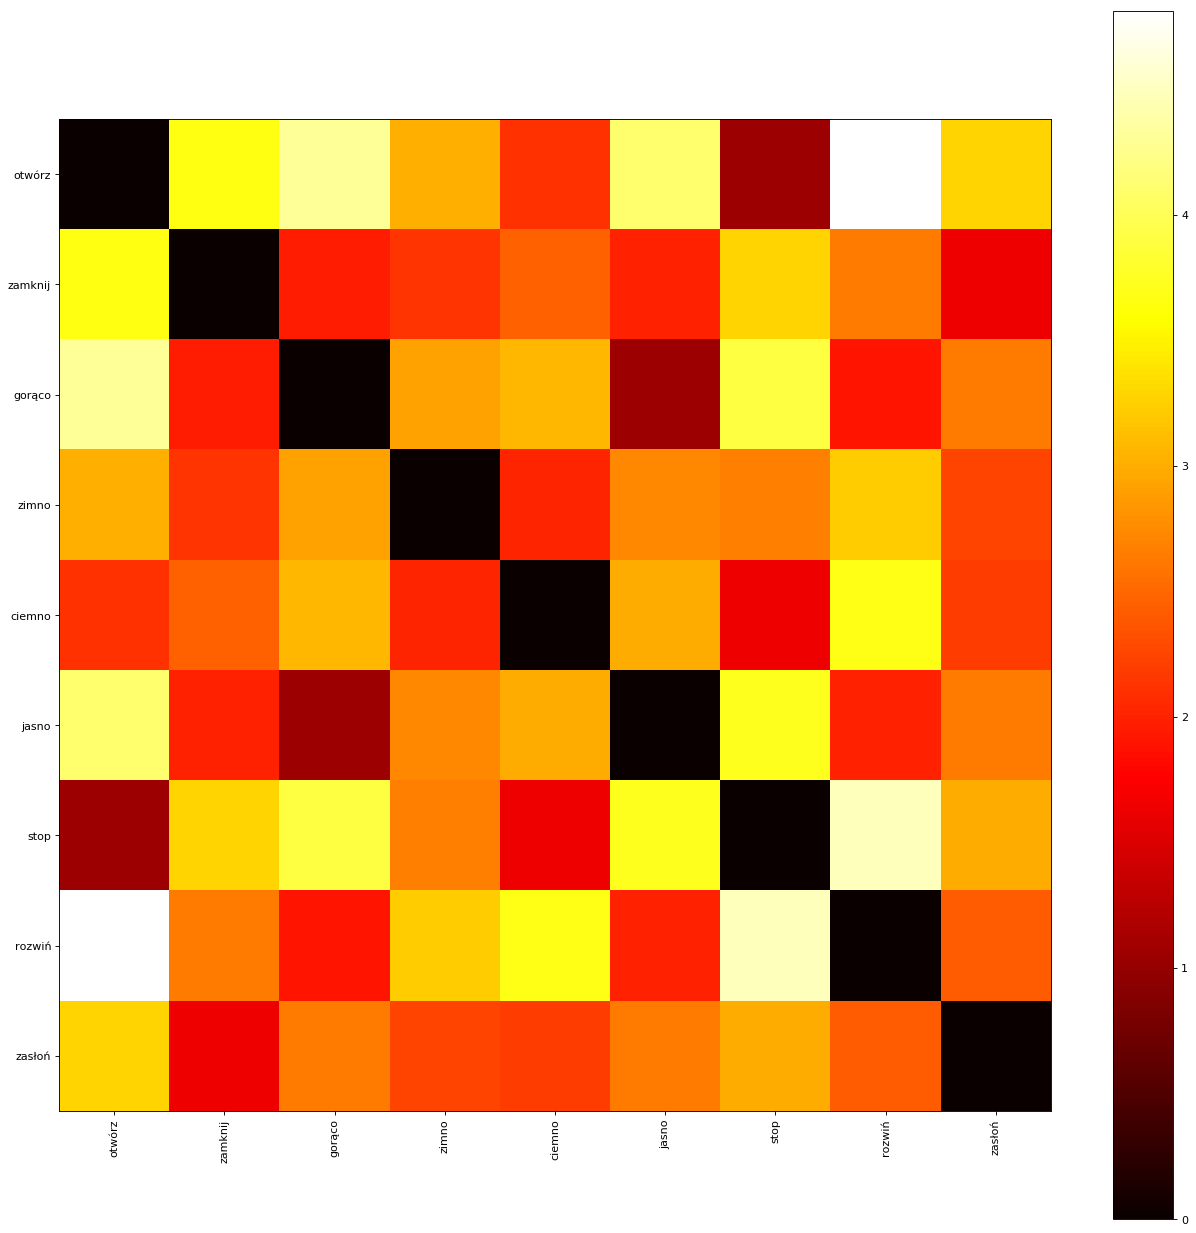

In [92]:
my_dist = np.ndarray(shape = (9, 9))
commands = ['otwórz', 'zamknij', 'gorąco', 'zimno', 'ciemno', 'jasno', 'stop', 'rozwiń', 'zasłoń']


dist, cost, acc_cost, path = dtw(otworz.T, otworz.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][0] = dist

dist, cost, acc_cost, path = dtw(zamknij.T, zamknij.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][1] = dist

dist, cost, acc_cost, path = dtw(goraco.T, goraco.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][2] = dist

dist, cost, acc_cost, path = dtw(zimno.T, zimno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[3][3] = dist

dist, cost, acc_cost, path = dtw(ciemno.T, ciemno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[4][4] = dist

dist, cost, acc_cost, path = dtw(jasno.T, jasno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[5][5] = dist

dist, cost, acc_cost, path = dtw(stop.T, stop.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[6][6] = dist

dist, cost, acc_cost, path = dtw(rozwin.T, rozwin.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[7][7] = dist

dist, cost, acc_cost, path = dtw(zaslon.T, zaslon.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[8][8] = dist


dist, cost, acc_cost, path = dtw(otworz.T, zamknij.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][1] = dist
my_dist[1][0] = dist

dist, cost, acc_cost, path = dtw(otworz.T, goraco.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][2] = dist
my_dist[2][0] = dist


dist, cost, acc_cost, path = dtw(otworz.T, zimno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][3] = dist
my_dist[3][0] = dist


dist, cost, acc_cost, path = dtw(otworz.T, ciemno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][4] = dist
my_dist[4][0] = dist


dist, cost, acc_cost, path = dtw(otworz.T, jasno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][5] = dist
my_dist[5][0] = dist

dist, cost, acc_cost, path = dtw(otworz.T, stop.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][6] = dist
my_dist[6][0] = dist


dist, cost, acc_cost, path = dtw(otworz.T, rozwin.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][7] = dist
my_dist[7][0] = dist


dist, cost, acc_cost, path = dtw(otworz.T, zaslon.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[0][8] = dist
my_dist[8][0] = dist


dist, cost, acc_cost, path = dtw(zamknij.T, goraco.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][2] = dist
my_dist[2][1] = dist


dist, cost, acc_cost, path = dtw(zamknij.T, zimno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][3] = dist
my_dist[3][1] = dist


dist, cost, acc_cost, path = dtw(zamknij.T, ciemno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][4] = dist
my_dist[4][1] = dist


dist, cost, acc_cost, path = dtw(zamknij.T, jasno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][5] = dist
my_dist[5][1] = dist


dist, cost, acc_cost, path = dtw(zamknij.T, stop.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][6] = dist
my_dist[6][1] = dist


dist, cost, acc_cost, path = dtw(zamknij.T, rozwin.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][7] = dist
my_dist[7][1] = dist

dist, cost, acc_cost, path = dtw(zamknij.T, zaslon.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[1][8] = dist
my_dist[8][1] = dist


dist, cost, acc_cost, path = dtw(goraco.T, zimno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][3] = dist
my_dist[3][2] = dist


dist, cost, acc_cost, path = dtw(goraco.T, ciemno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][4] = dist
my_dist[4][2] = dist


dist, cost, acc_cost, path = dtw(goraco.T, jasno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][5] = dist
my_dist[5][2] = dist

dist, cost, acc_cost, path = dtw(goraco.T, stop.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][6] = dist
my_dist[6][2] = dist


dist, cost, acc_cost, path = dtw(goraco.T, rozwin.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][7] = dist
my_dist[7][2] = dist


dist, cost, acc_cost, path = dtw(goraco.T, zaslon.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[2][8] = dist
my_dist[8][2] = dist




dist, cost, acc_cost, path = dtw(zimno.T, ciemno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[3][4] = dist
my_dist[4][3] = dist


dist, cost, acc_cost, path = dtw(zimno.T, jasno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[3][5] = dist
my_dist[5][3] = dist


dist, cost, acc_cost, path = dtw(zimno.T, stop.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[3][6] = dist
my_dist[6][3] = dist

dist, cost, acc_cost, path = dtw(zimno.T, rozwin.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[3][7] = dist
my_dist[7][3] = dist


dist, cost, acc_cost, path = dtw(zimno.T, zaslon.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[3][8] = dist
my_dist[8][3] = dist




dist, cost, acc_cost, path = dtw(ciemno.T, jasno.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[4][5] = dist
my_dist[5][4] = dist

dist, cost, acc_cost, path = dtw(ciemno.T, stop.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[4][6] = dist
my_dist[6][4] = dist


dist, cost, acc_cost, path = dtw(ciemno.T, rozwin.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[4][7] = dist
my_dist[7][4] = dist


dist, cost, acc_cost, path = dtw(ciemno.T, zaslon.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[4][8] = dist
my_dist[8][4] = dist




dist, cost, acc_cost, path = dtw(jasno.T, stop.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[5][6] = dist
my_dist[6][5] = dist


dist, cost, acc_cost, path = dtw(jasno.T, rozwin.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[5][7] = dist
my_dist[7][5] = dist


dist, cost, acc_cost, path = dtw(jasno.T, zaslon.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[5][8] = dist
my_dist[8][5] = dist



dist, cost, acc_cost, path = dtw(stop.T, rozwin.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[6][7] = dist
my_dist[7][6] = dist


dist, cost, acc_cost, path = dtw(stop.T, zaslon.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[6][8] = dist
my_dist[8][6] = dist


dist, cost, acc_cost, path = dtw(rozwin.T, zaslon.T, dist=lambda x, y: np.linalg.norm(x - y, ord=1))
my_dist[7][8] = dist
my_dist[8][7] = dist


plt.figure(figsize=(20,20), dpi= 80, facecolor='w', edgecolor='k')
plt.imshow(my_dist, cmap='hot')
plt.colorbar()
plt.tick_params(axis = 'on', bottom='off', top='on', labelbottom='off', labeltop='on')
plt.xticks(range(len(my_dist)), commands, rotation=90)
plt.yticks(range(len(my_dist)), commands)
plt.show()


